In [43]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer


sys.path.append(os.path.abspath('..'))

from dataframe_generator import *
from image_patching import *

In [44]:
df, split_variables = create_dataframe()
df

                             image_path category
0        ../data/CBIR_15-Scene/00/1.jpg  Bedroom
1        ../data/CBIR_15-Scene/00/2.jpg  Bedroom
2        ../data/CBIR_15-Scene/00/3.jpg  Bedroom
3        ../data/CBIR_15-Scene/00/4.jpg  Bedroom
4        ../data/CBIR_15-Scene/00/5.jpg  Bedroom
...                                 ...      ...
4480  ../data/CBIR_15-Scene/14/4481.jpg    Store
4481  ../data/CBIR_15-Scene/14/4482.jpg    Store
4482  ../data/CBIR_15-Scene/14/4483.jpg    Store
4483  ../data/CBIR_15-Scene/14/4484.jpg    Store
4484  ../data/CBIR_15-Scene/14/4485.jpg    Store

[4485 rows x 2 columns]


image_path category
0        ../data/CBIR_15-Scene/00/1.jpg  Bedroom
1        ../data/CBIR_15-Scene/00/2.jpg  Bedroom
2        ../data/CBIR_15-Scene/00/3.jpg  Bedroom
3        ../data/CBIR_15-Scene/00/4.jpg  Bedroom
4        ../data/CBIR_15-Scene/00/5.jpg  Bedroom
...                                 ...      ...
4480  ../data/CBIR_15-Scene/14/4481.jpg    Store
4481  ../data/CBIR_15-Scene/14/4482.jpg    Store
4482  ../data/CBIR_15-Scene/14/4483.jpg    Store
4483  ../data/CBIR_15-Scene/14/4484.jpg    Store
4484  ../data/CBIR_15-Scene/14/4485.jpg    Store

[4485 rows x 2 columns]

# Now we are going to work with 2 similar environments

In [45]:
df_similar = df[df['category'].isin(['Bedroom', 'LivingRoom'])]
df_similar

image_path    category
0        ../data/CBIR_15-Scene/00/1.jpg     Bedroom
1        ../data/CBIR_15-Scene/00/2.jpg     Bedroom
2        ../data/CBIR_15-Scene/00/3.jpg     Bedroom
3        ../data/CBIR_15-Scene/00/4.jpg     Bedroom
4        ../data/CBIR_15-Scene/00/5.jpg     Bedroom
...                                 ...         ...
1262  ../data/CBIR_15-Scene/04/1263.jpg  LivingRoom
1263  ../data/CBIR_15-Scene/04/1264.jpg  LivingRoom
1264  ../data/CBIR_15-Scene/04/1265.jpg  LivingRoom
1265  ../data/CBIR_15-Scene/04/1266.jpg  LivingRoom
1266  ../data/CBIR_15-Scene/04/1267.jpg  LivingRoom

[505 rows x 2 columns]

In [46]:
X = df_similar['image_path']
y = df_similar['category']
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=10)


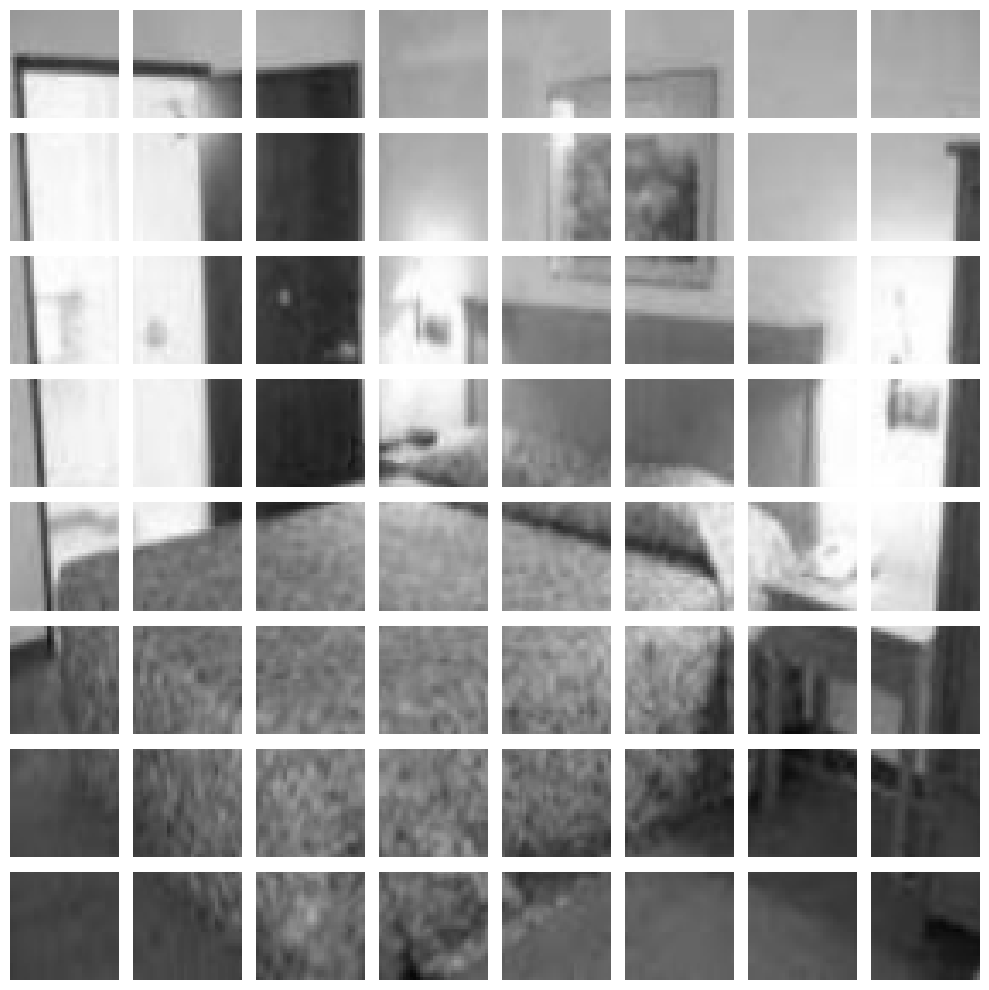

In [47]:
# Função para criar a grid de patches
def plot_patches_grid(patches, patch_size, grid_shape):
    fig, axes = plt.subplots(grid_shape[0], grid_shape[1], figsize=(10, 10))
    patch_idx = 0
    for i in range(grid_shape[0]):
        for j in range(grid_shape[1]):
            if patch_idx < len(patches):
                axes[i, j].imshow(cv2.cvtColor(patches[patch_idx], cv2.COLOR_BGR2RGB))
                axes[i, j].axis('off')
                patch_idx += 1
            else:
                axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

patch_size = (32,32)

# Carregar a primeira imagem de treino e criar os patches
first_image_path = X_train.iloc[0]
image = cv2.imread(first_image_path)
resized_image = resize_image(image, standard_size)
patches, positions = create_patches(resized_image, patch_size)

# Determinar o número de patches na grid
grid_rows = resized_image.shape[0] // patch_size[0]
grid_cols = resized_image.shape[1] // patch_size[1]

# Plotar a grid de patches
plot_patches_grid(patches, patch_size, (grid_rows, grid_cols))


In [48]:
create_images_set(X_train, X_test, y_train, y_test, patch_size, output_dir_train='patches_train', output_dir_test='patches_test')

In [49]:
patches_by_category = load_patches_by_category('patches_train', y, patch_size)


In [50]:
# Função para imputar NaNs
def impute_nans(patches):
    imputer = SimpleImputer(strategy='mean')
    patches = imputer.fit_transform(patches)
    return patches

def normalize_patches(patches):
    patches = patches.astype(np.float32)
    mean = np.mean(patches, axis=0)
    std = np.std(patches, axis=0)
    normalized_patches = (patches - mean) / (std)
    return normalized_patches


# Normalizar patches para cada categoria
normalized_patches_by_category = {}
for category, patches in patches_by_category.items():
    normalized_patches = normalize_patches(patches)
    normalized_patches_by_category[category] = normalized_patches  
    

In [51]:
from sklearn.decomposition import PCA
# Aplicar PCA para cada categoria e visualizar componentes
def apply_pca_and_visualize(patches_by_category, n_components=1024):
    pca_by_category = {}
    num_components_95_dict = {}
    for category, patches in patches_by_category.items():
        print(patches)
        if patches.size == 0:
            continue  # Pular se não houver patches para esta categoria
        
        #patches = impute_nans(patches)

        # Normalizar patches
        #patches = normalize_patches(patches)
        
        pca = PCA(n_components=n_components)
        pca.fit(patches)
        components = pca.components_
        variance = pca.explained_variance_
        
        # Plotar os 320 primeiros componentes principais
        fig, axes = plt.subplots(16, 20, figsize=(20, 16))
        for i, ax in enumerate(axes.flatten()):
            ax.imshow(components[i].reshape(32, 32), cmap='gray')
            ax.axis('off')
        plt.suptitle(f'{n_components} Principal Components  - Category: {category}')
        plt.show()
        
        # Plotar a log-variância dos componentes principais
        plt.figure(figsize=(10, 6))
        plt.plot(np.log(variance))
        plt.title(f'Log-Variace of Principal Components - Category: {category}')
        plt.xlabel('Index of the Principal Component')
        plt.ylabel('Log-Variance')
        plt.grid(True)
        plt.show()

        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        num_components_95 = np.where(cumulative_variance >= 0.95)[0][0] + 1

        #We take the PCA with the minimum significant components
        pca = PCA(n_components=num_components_95)
        pca.fit(patches)

        pca_by_category[category] = pca
        num_components_95_dict[category] = num_components_95

        print("Category: " + category)
        print("Number of components that explain 95% of variance: " + str(num_components_95))

    
    min_num_components = min(num_components_95_dict.values())
    return pca_by_category,num_components_95_dict, min_num_components

[[ 1.7118474   1.700488    1.7254769  ...  1.9218178   1.915255
   1.9043345 ]
 [ 1.742943    1.7317482   1.7411486  ...  1.9218178   1.915255
   1.9043345 ]
 [ 0.4369238   0.48134065  0.55010056 ...  1.739715    1.7183379
   1.7088455 ]
 ...
 [ 0.5457587   0.5594911   0.55010056 ...  0.05526423  0.0369691
   0.02463163]
 [ 1.8206823   1.5754472   0.628459   ... -0.62762123 -0.58407706
  -0.4415347 ]
 [ 0.8878114   0.0749582  -0.1394535  ... -0.35446703 -0.38715997
  -0.41145945]]


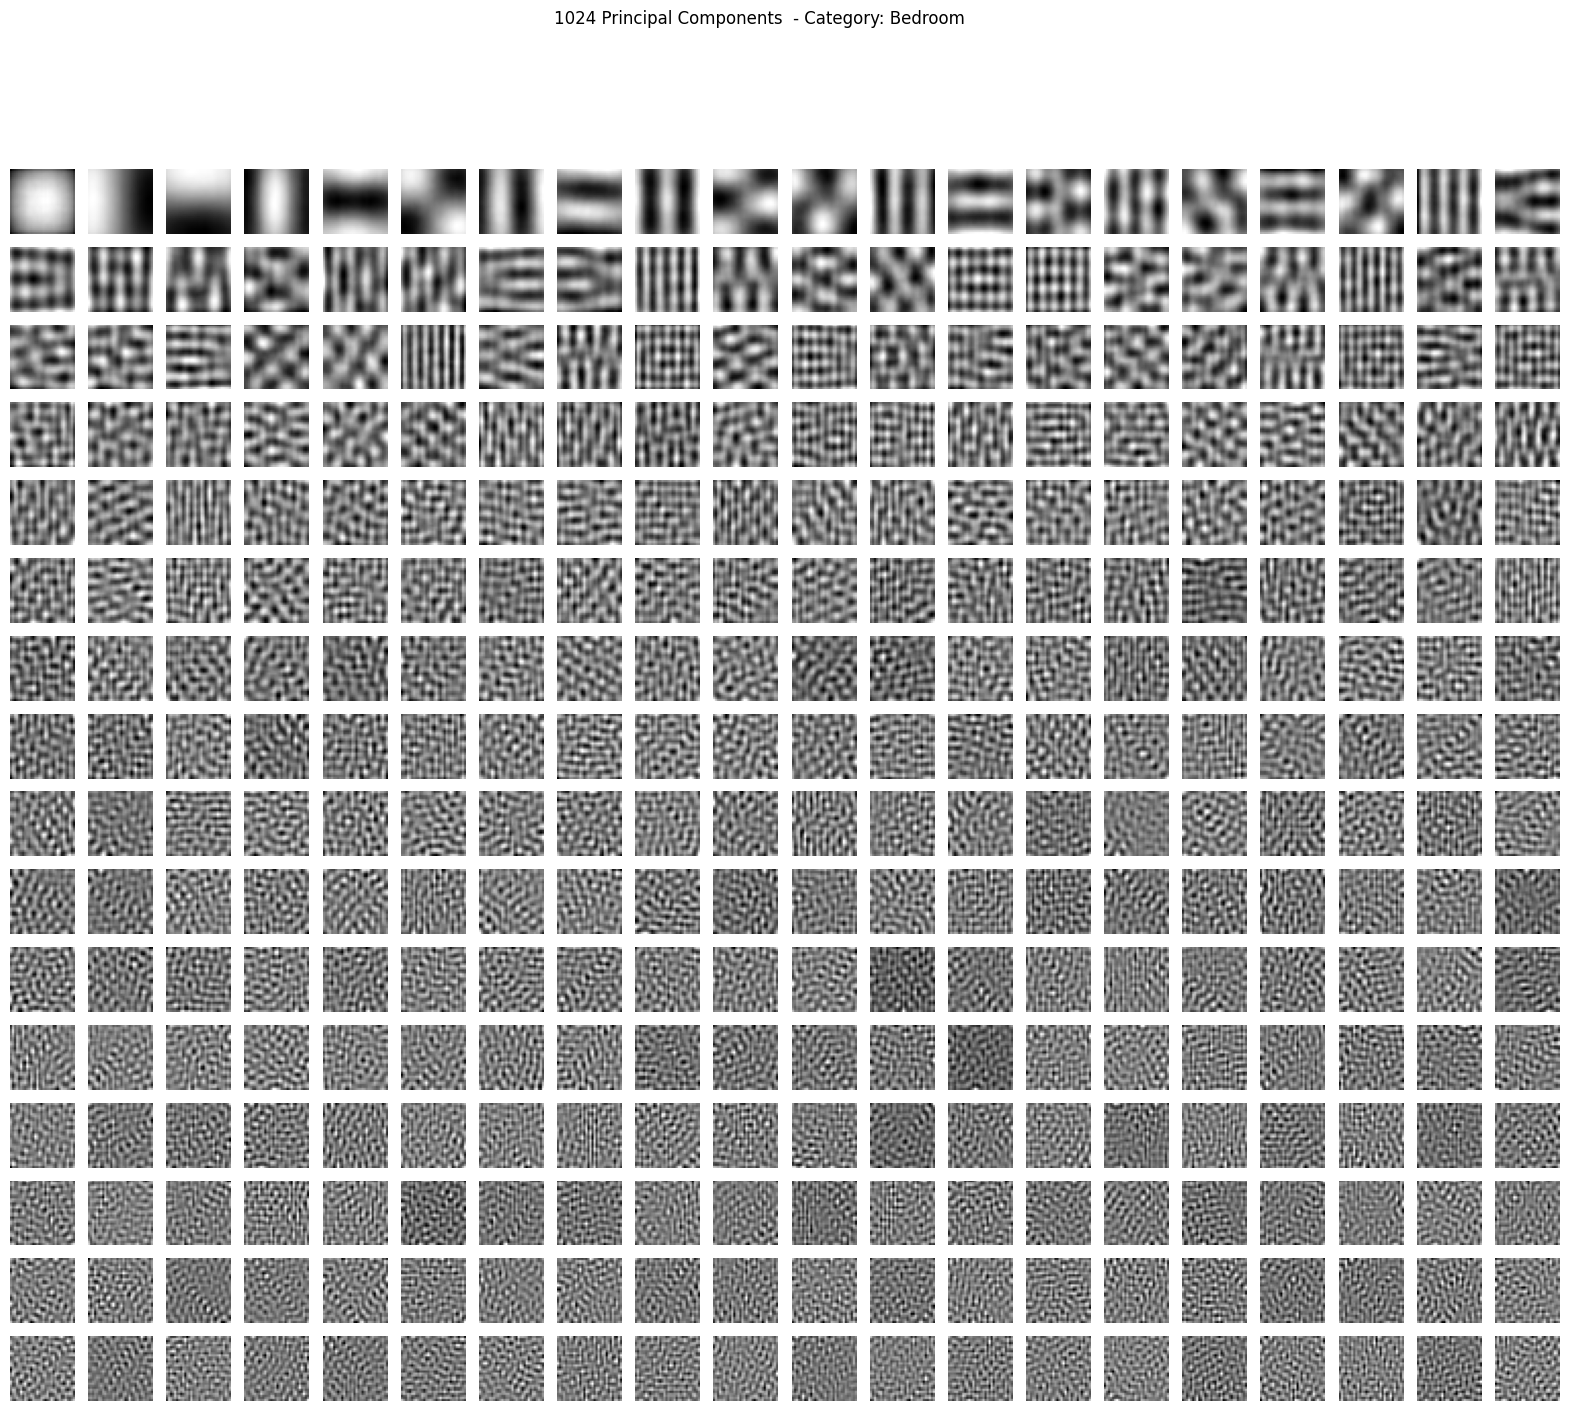

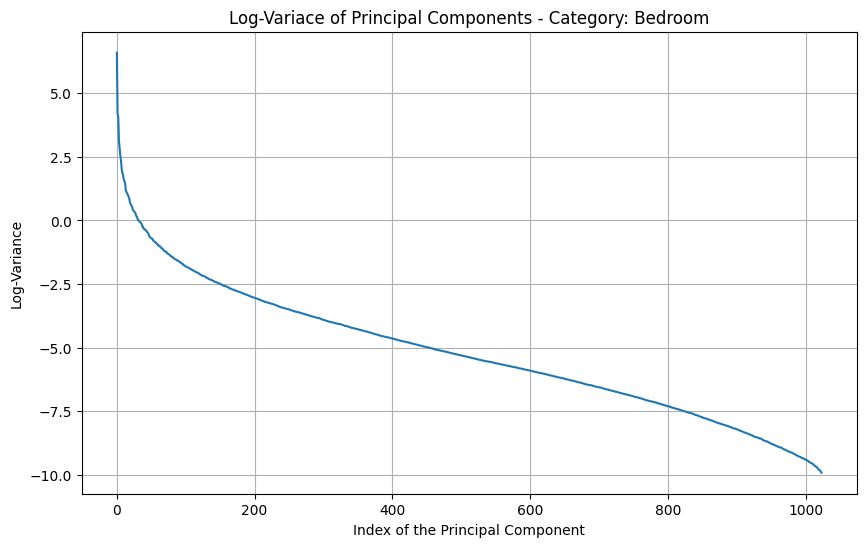

Category: Bedroom
Number of components that explain 95% of variance: 26
[[ 0.00542704 -0.0232404  -0.02204517 ...  0.2149753   0.1985061
   0.18183683]
 [-1.0326632  -1.0202795  -1.019239   ...  1.453337    1.4659077
   1.5652363 ]
 [ 0.48686022  0.50549245  0.37078875 ... -0.44951144 -0.17869674
  -0.49482593]
 ...
 [-0.43087178 -0.7634664  -0.777495   ...  0.01864968  0.00236063
   0.04650427]
 [-1.1981559  -1.216666   -1.2156559  ...  2.027212    1.9939917
   1.9862709 ]
 [ 0.21605405  0.0069729  -0.14291716 ...  0.5925246   0.48518026
   0.6028714 ]]


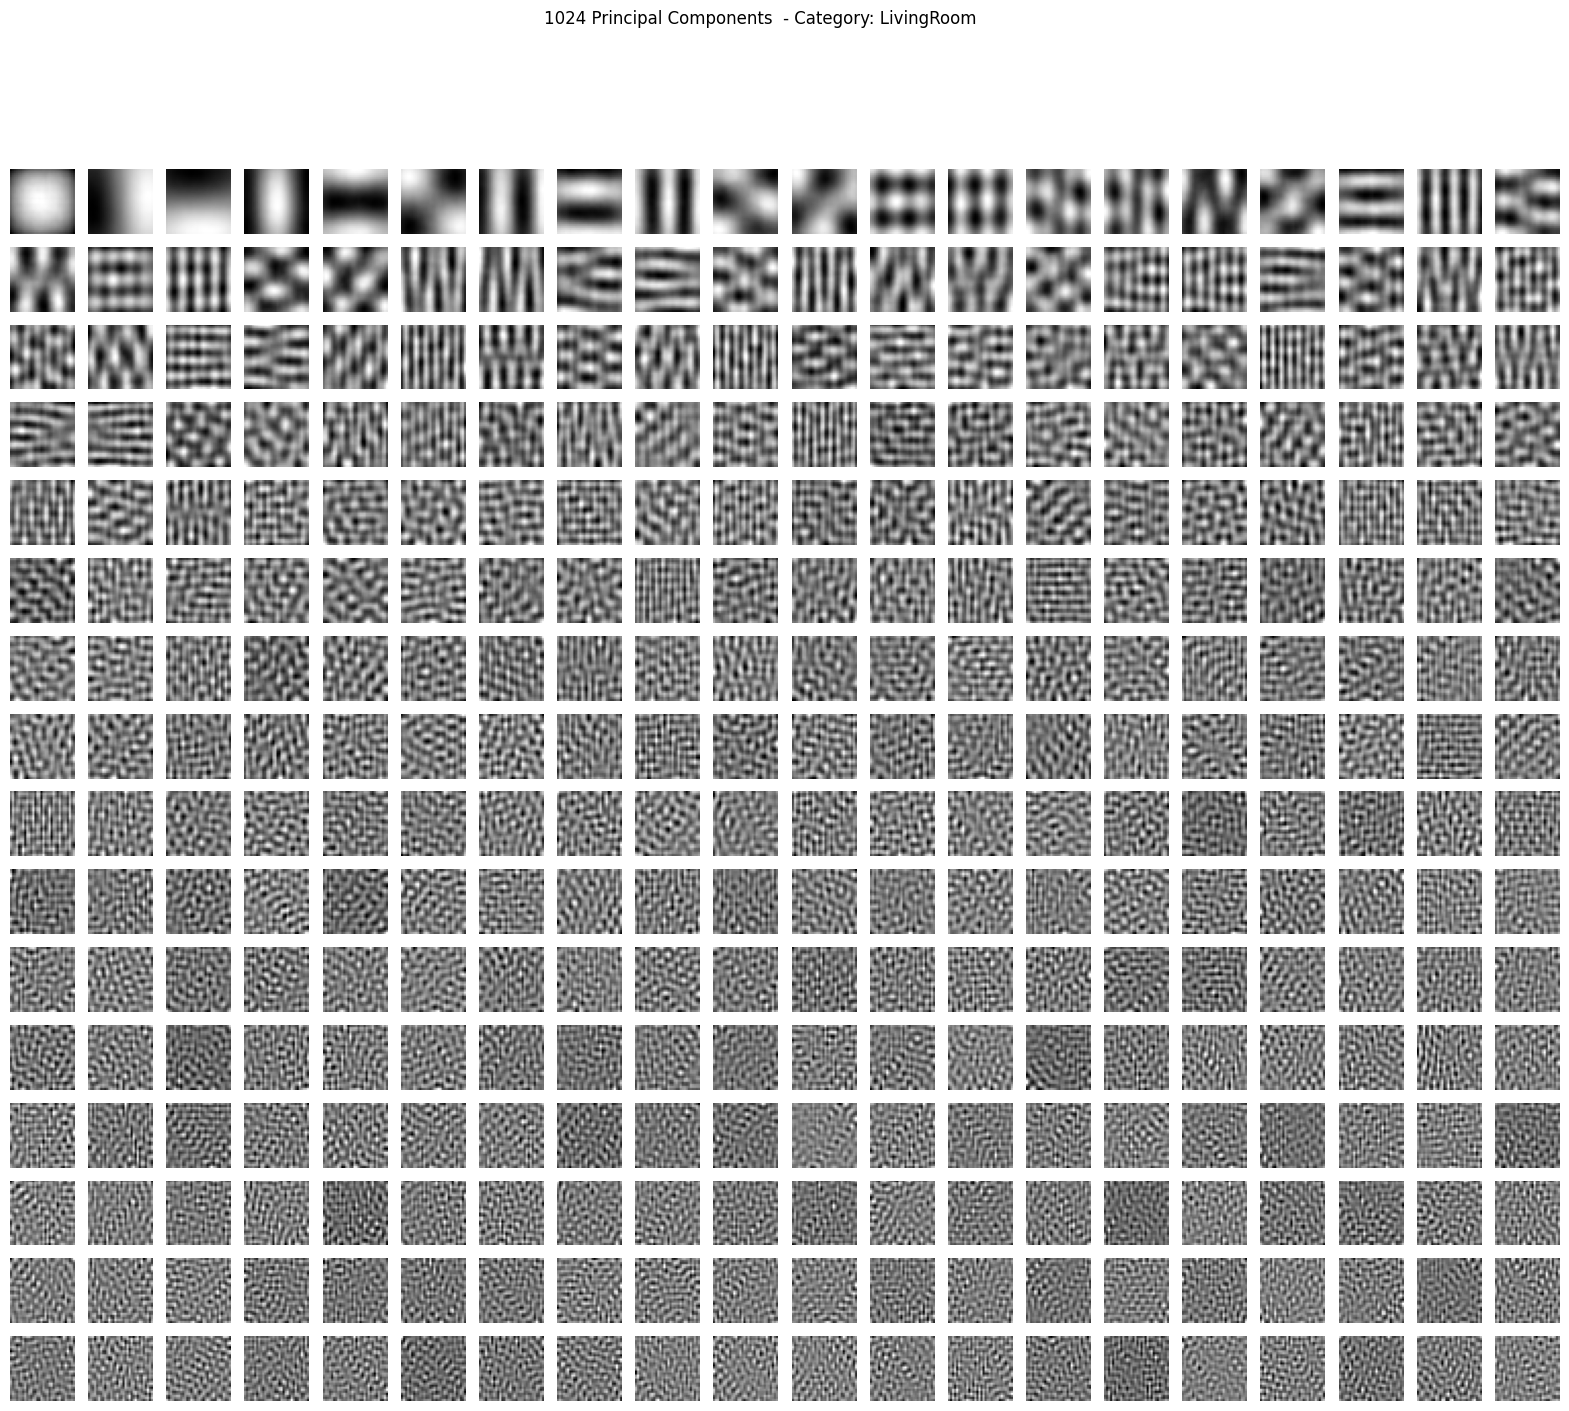

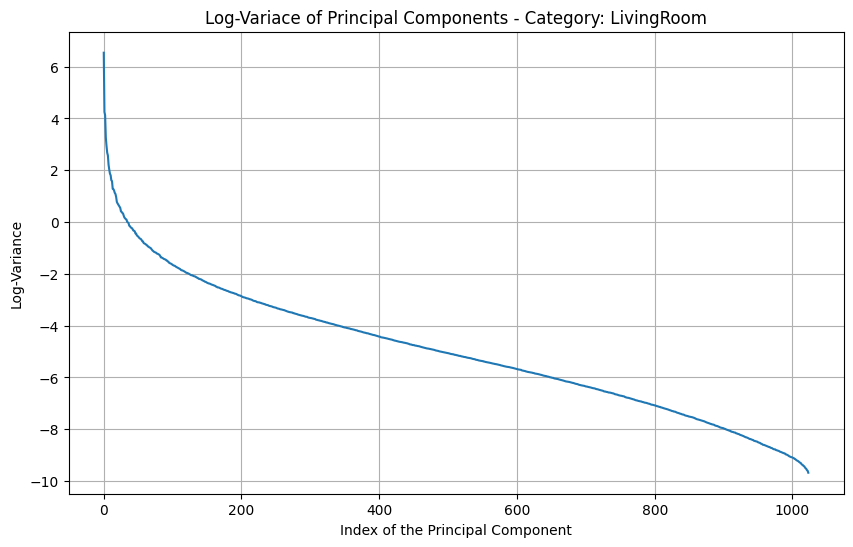

Category: LivingRoom
Number of components that explain 95% of variance: 31
{'Bedroom': PCA(n_components=26), 'LivingRoom': PCA(n_components=31)}


In [52]:
pca_by_category, nummin_components_95_dict, min_components = apply_pca_and_visualize(normalized_patches_by_category)
print(pca_by_category)

In [53]:
def compute_residuals_with_pca(patches_by_category, pca_by_category):
    residuals = {}
    for category, patches in patches_by_category.items():
        if patches.size == 0:
            continue  # Pular se não houver patches para esta categoria

        # Normalizar patches
        #patches = normalize_patches(patches)

        # Obter PCA da categoria
        pca = pca_by_category[category] #usar o pc com minimo de dimensoes

        # Projetar dados nos componentes principais
        projected_data = pca.transform(patches)
        # Reconstruir dados a partir da projeção
        reconstructed_data = pca.inverse_transform(projected_data)
        # Calcular os resíduos
        residuals[category] = patches - reconstructed_data
    return residuals


residuals_by_category = compute_residuals_with_pca(normalized_patches_by_category, pca_by_category)


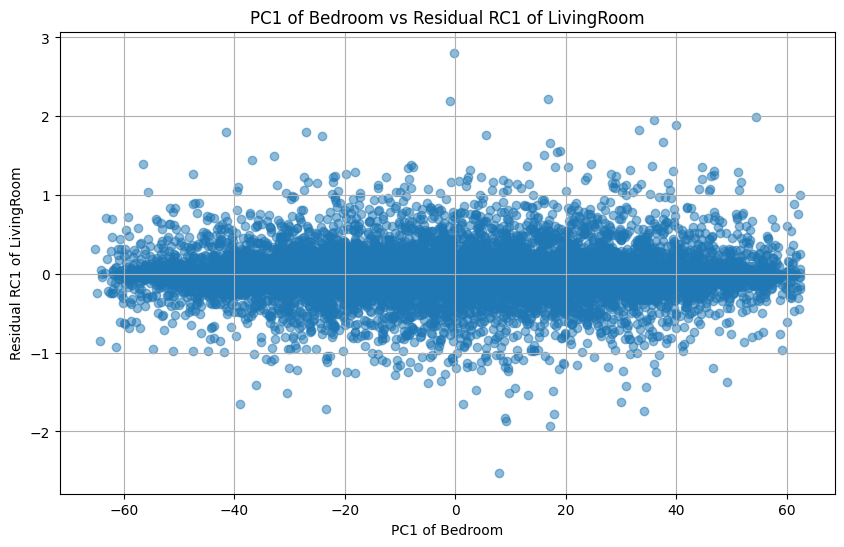

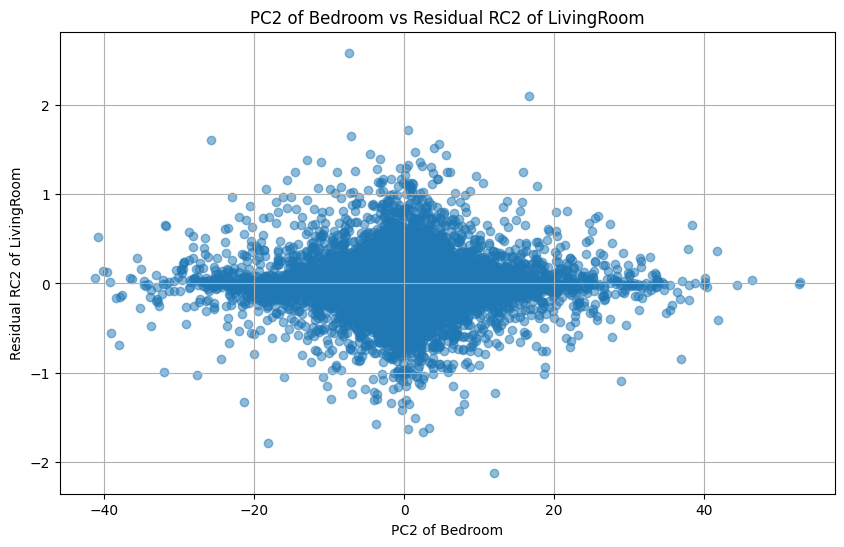

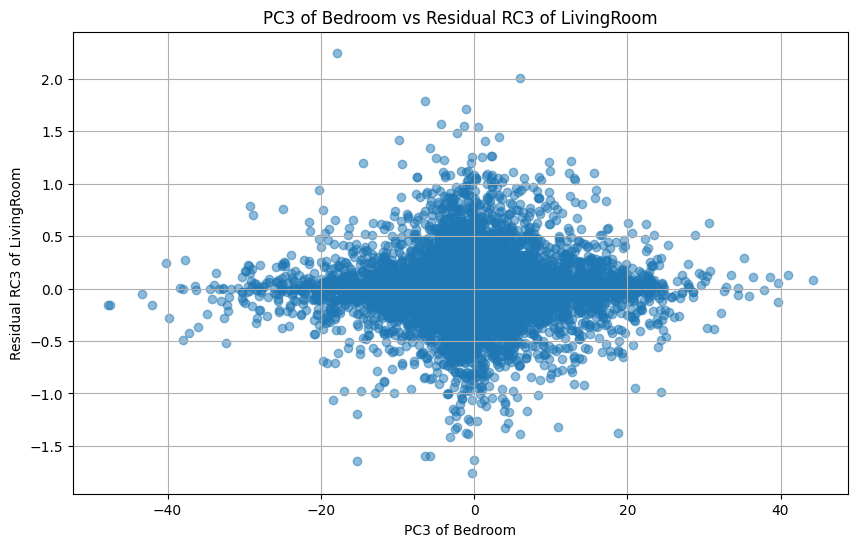

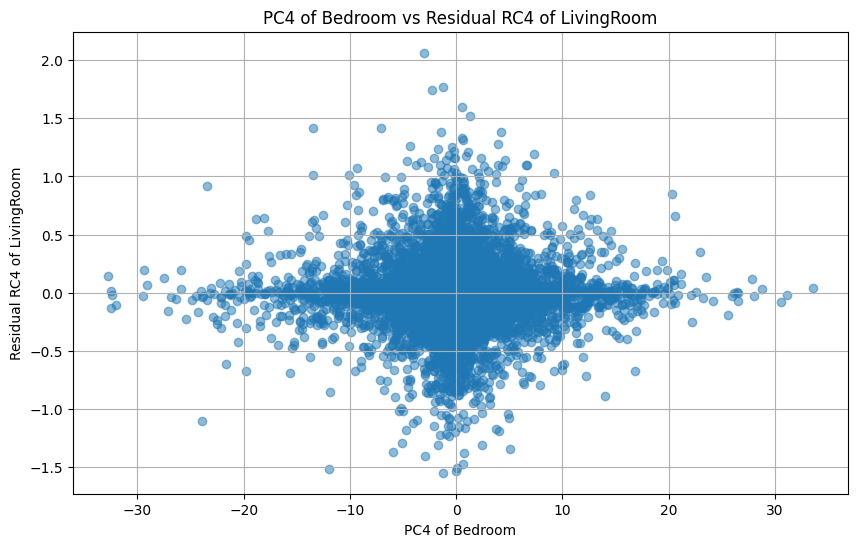

In [54]:
# Extrair dados do primeiro ambiente (Bedroom)
first_environment = 'Bedroom'
first_environment_patches = normalized_patches_by_category[first_environment]
first_environment_pca = pca_by_category[first_environment]

first_environment_residuals = residuals_by_category[first_environment]

# Extrair dados do segundo ambiente (LivingRoom)
second_environment = 'LivingRoom'
second_environment_residuals = residuals_by_category[second_environment]

# Número de componentes principais a comparar
num_components_to_compare = 5

# Plotar os dados para cada componente principal até num_components_to_compare
for i in range(num_components_to_compare):
    projected_PC_bedroom = first_environment_pca.transform(first_environment_patches)[:, i]
    residuals_PC_LivingRoom = second_environment_residuals[:, i]

    # Garantir que ambos os arrays tenham o mesmo tamanho
    min_length = min(len(projected_PC_bedroom), len(residuals_PC_LivingRoom))
    projected_PC_bedroom = projected_PC_bedroom[:min_length]
    residuals_PC_LivingRoom = residuals_PC_LivingRoom[:min_length]

    # Plotar os dados
    plt.figure(figsize=(10, 6))
    plt.scatter(projected_PC_bedroom, residuals_PC_LivingRoom, alpha=0.5)
    plt.title(f"PC{i+1} of Bedroom vs Residual RC{i+1} of LivingRoom")
    plt.xlabel(f"PC{i+1} of Bedroom")
    plt.ylabel(f"Residual RC{i+1} of LivingRoom")
    plt.grid(True)
    plt.show()

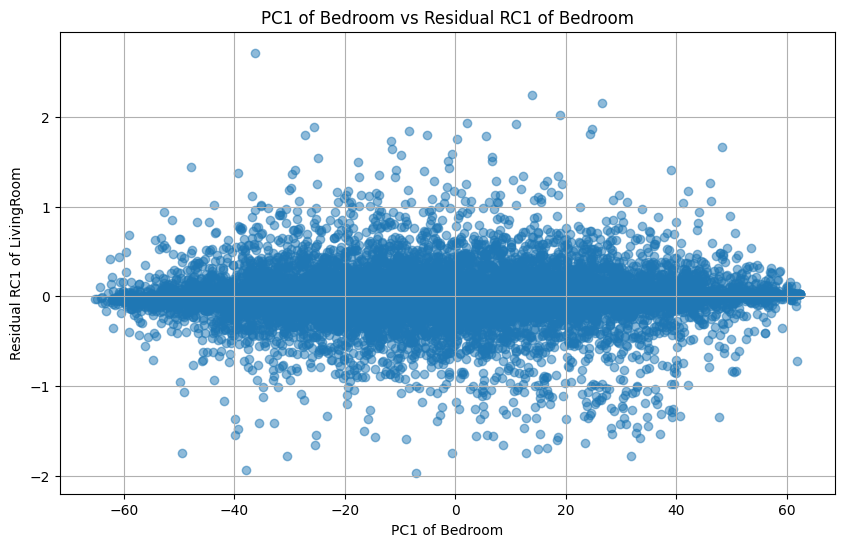

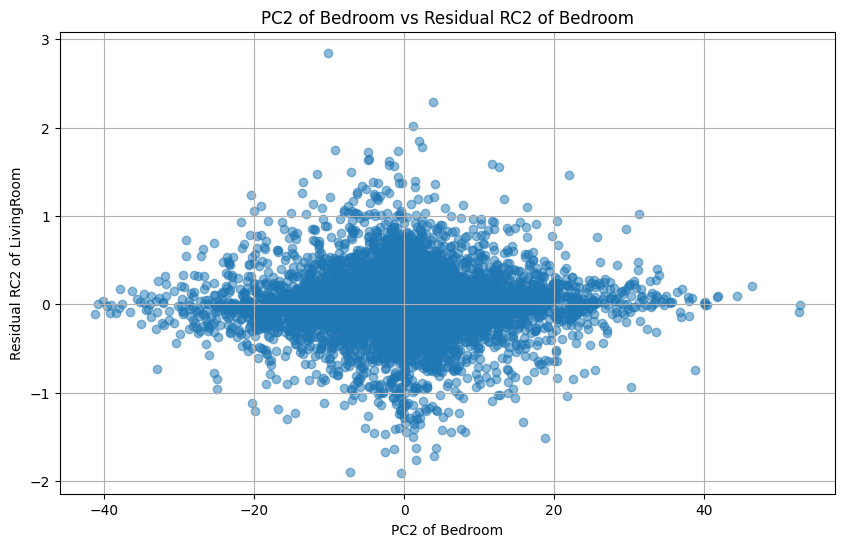

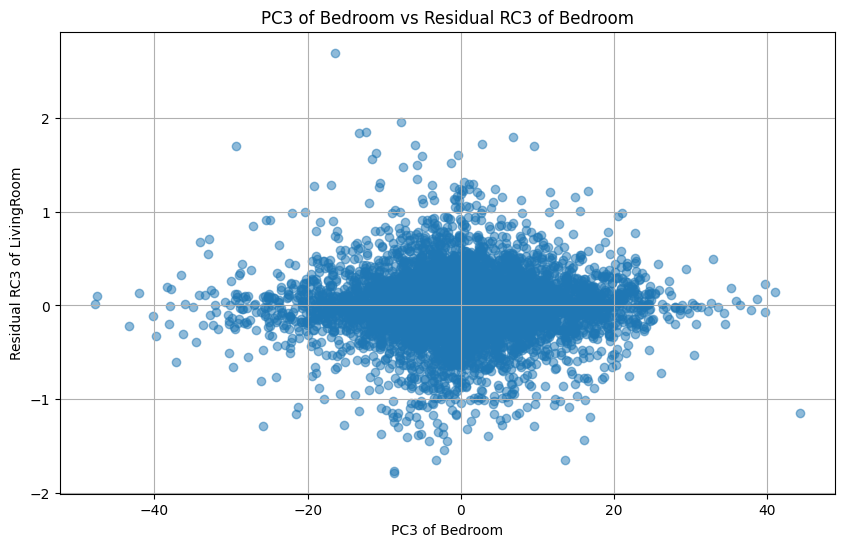

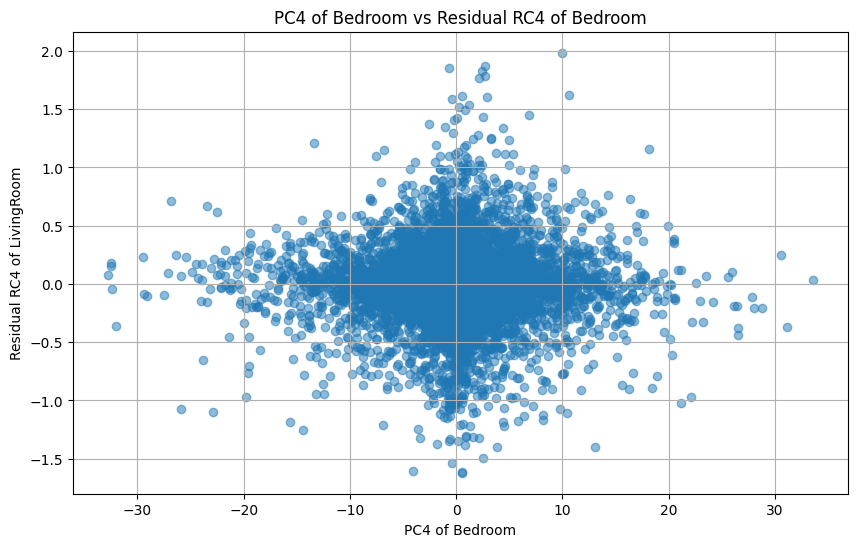

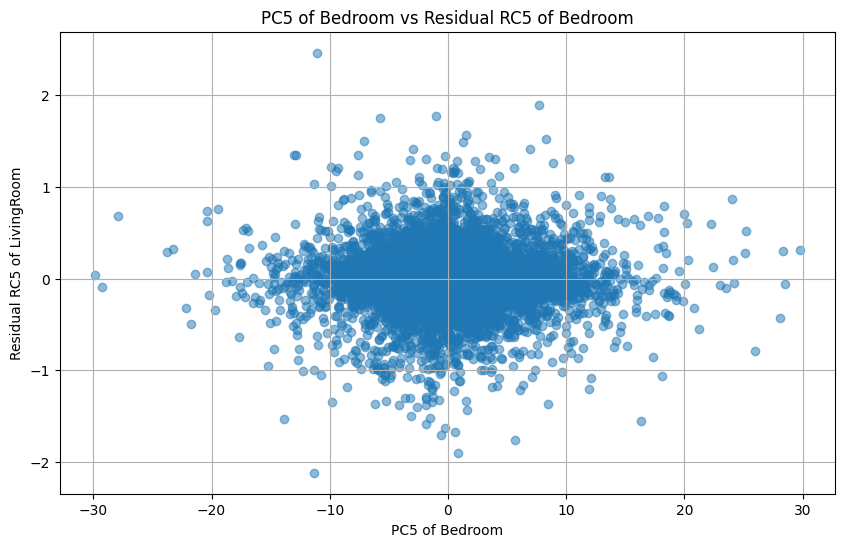

In [55]:
for i in range(num_components_to_compare):
    projected_PC_bedroom = first_environment_pca.transform(first_environment_patches)[:, i]
    residuals_PC_bedroom= first_environment_residuals[:, i]

    # Garantir que ambos os arrays tenham o mesmo tamanho
    min_length = min(len(projected_PC_bedroom), len(residuals_PC_bedroom))
    projected_PC_bedroom = projected_PC_bedroom[:min_length]
    residuals_PC_bedroom = residuals_PC_bedroom[:min_length]

    # Plotar os dados
    plt.figure(figsize=(10, 6))
    plt.scatter(projected_PC_bedroom, residuals_PC_bedroom, alpha=0.5)
    plt.title(f"PC{i+1} of Bedroom vs Residual RC{i+1} of Bedroom")
    plt.xlabel(f"PC{i+1} of Bedroom")
    plt.ylabel(f"Residual RC{i+1} of LivingRoom")
    plt.grid(True)
    plt.show()

In [60]:
# Função para calcular a métrica OOD para uma imagem individual
def calculate_ood_for_image(image, pca, residuals_by_category):
    print(f'image: {image}')
    image = image.reshape(1, -1) 
    projected_data = pca.transform(image)
    reconstructed_data = pca.inverse_transform(projected_data)
    residual = image - reconstructed_data

    
    norm_residual = np.linalg.norm(residual)
    print("NORM RESIDUAL: " + str(norm_residual))
    norm_image = np.linalg.norm(image)
    print("NORM IMAGE: " + str(norm_image))
    
    ood_metric = norm_residual / (norm_image)
    return ood_metric

# Calcular a métrica OOD para cada patch do Bedroom
def calculate_ood_for_patches(patches, pca, residuals_by_category):
    ood_metrics = []
    for patch in patches:
        print(patch)
        ood_metric = calculate_ood_for_image(patch, pca, residuals_by_category)
        ood_metrics.append(ood_metric)
    return np.array(ood_metrics)

In [57]:
test_patches_by_category = load_patches_by_category('patches_test', y, patch_size)

[-0.05559662 -0.19428495 -0.41875413 ...  0.6037436   0.57826084
  0.5588932 ]
image: [-0.05559662 -0.19428495 -0.41875413 ...  0.6037436   0.57826084
  0.5588932 ]
NORM RESIDUAL: 2.5133908
NORM IMAGE: 15.462338
[1.8857268  1.8326061  1.9122947  ... 0.27783322 0.22257864 0.1435035 ]
image: [1.8857268  1.8326061  1.9122947  ... 0.27783322 0.22257864 0.1435035 ]
NORM RESIDUAL: 6.9437904
NORM IMAGE: 31.043877
[-1.3813784 -1.4710667 -1.6162108 ... -1.4448359 -1.4785101 -1.4872856]
image: [-1.3813784 -1.4710667 -1.6162108 ... -1.4448359 -1.4785101 -1.4872856]
NORM RESIDUAL: 2.2069407
NORM IMAGE: 49.661377
[-0.19764467  0.01319209 -0.16329671 ...  0.65030223  0.60918975
  0.574278  ]
image: [-0.19764467  0.01319209 -0.16329671 ...  0.65030223  0.60918975
  0.574278  ]
NORM RESIDUAL: 2.278035
NORM IMAGE: 21.954668
[0.43368    0.46006572 0.47534683 ... 0.758939   0.7483697  0.75889564]
image: [0.43368    0.46006572 0.47534683 ... 0.758939   0.7483697  0.75889564]
NORM RESIDUAL: 0.38256645
NORM

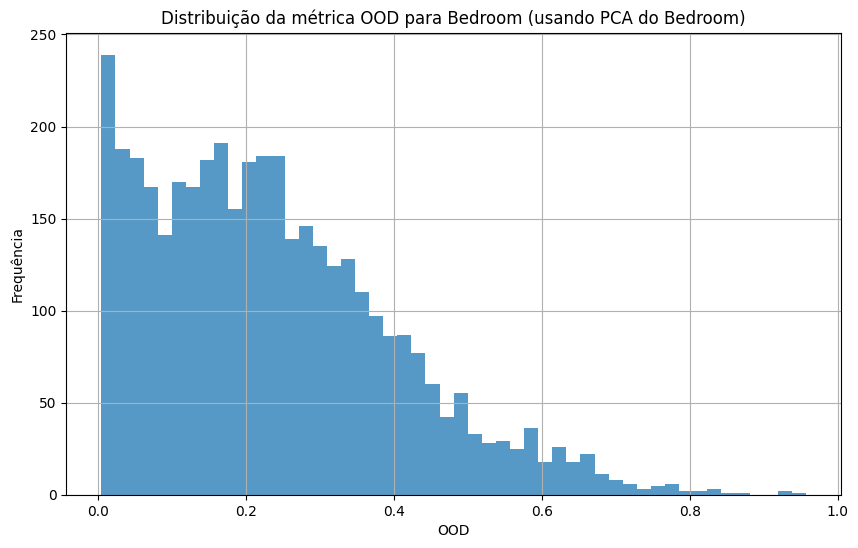

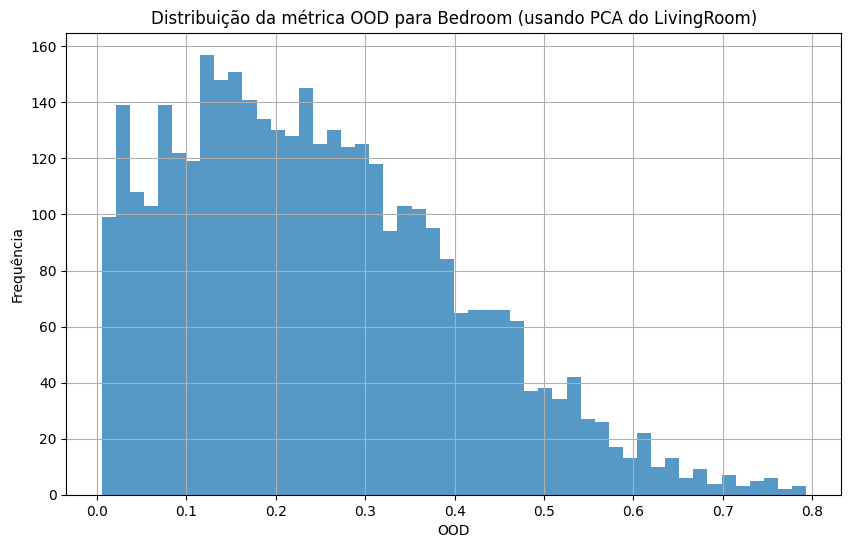

In [61]:
patches_bedroom = test_patches_by_category['Bedroom']
patches_LivingRoom = test_patches_by_category['LivingRoom']

#Normalizar os patches
normalized_patches_bedroom = normalize_patches(patches_bedroom)
normalized_patches_livingroom= normalize_patches(patches_LivingRoom)

# Calcular a métrica OOD para cada patch do Bedroom usando PCA do Bedroom
ood_metrics_bedroom_bedroom = calculate_ood_for_patches(normalized_patches_bedroom, first_environment_pca, first_environment_residuals)

# Calcular a métrica OOD para cada patch do Livingroom usando PCA do Bedroom
ood_metrics_bedroom_LivingRoom = calculate_ood_for_patches(normalized_patches_livingroom, first_environment_pca, first_environment_residuals)

# Visualizar a distribuição dos valores de OOD para Bedroom usando PCA do Bedroom
plt.figure(figsize=(10, 6))
plt.hist(ood_metrics_bedroom_bedroom, bins=50, alpha=0.75)
plt.title(f"Distribuição da métrica OOD para Bedroom (usando PCA do Bedroom)")
plt.xlabel("OOD")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()

# Visualizar a distribuição dos valores de OOD para Bedroom usando PCA do Living Room
plt.figure(figsize=(10, 6))
plt.hist(ood_metrics_bedroom_LivingRoom, bins=50, alpha=0.75)
plt.title(f"Distribuição da métrica OOD para Bedroom (usando PCA do LivingRoom)")
plt.xlabel("OOD")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()

In [62]:
# Calcular a média dos valores de OOD
mean_ood_bedroom_bedroom = np.mean(ood_metrics_bedroom_bedroom)
mean_ood_bedroom_LivingRoom = np.mean(ood_metrics_bedroom_LivingRoom)

# Verificar os valores calculados de OOD
print("Mean OOD metric for Bedroom using Bedroom PCA: ", mean_ood_bedroom_bedroom)
print("Mean OOD metric for Bedroom using LivingRoom PCA: ", mean_ood_bedroom_LivingRoom)

Mean OOD metric for Bedroom using Bedroom PCA:  0.23568703
Mean OOD metric for Bedroom using LivingRoom PCA:  0.24896125
